In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic

C:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
print(dataA1.shape)
print(dataA2.shape)

print(dataA2.columns)

(3631, 51)
(664995, 51)
Index(['發生年度', '發生月份', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度'],
      dtype='object')


In [4]:
# select_lst = [
#     '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
#     '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', 
#     '號誌-號誌種類名稱', '號誌-號誌動作名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', 
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', 
#     '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '事故類型及型態大類別名稱', '事故位置大類別名稱',
#     '死亡受傷人數',
# ]
# print(len(select_lst))
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 4]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

22


In [5]:
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]

rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

(96846, 192)


In [7]:
data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

pca = PCA(n_components=5)
lens1 = pca.fit_transform(mapper_numpy)

# 查看每個主成分保留的變異量比例
explained_variance_ratio  = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumulative_variance_ratio)
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

[0.2285175  0.34289305 0.40947325 0.46745708 0.5152317 ]
0.515231700878357
[0.2285175  0.11437556 0.0665802  0.05798383 0.04777462]


PCA視覺化效果不好

In [ ]:
# import plotly.express as px

# df = pd.DataFrame(lens1, columns=['PC1', 'PC2', 'PC3'])
# fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', title="PCA 3D Scatter Plot")
# fig.show()

n_neighbors越大越注重全局結構，5 到 50 ，5~15適合高維度<br/>
min_dist影響緊密程度，越大越稀疏，通常在0.0 到 0.5

In [9]:
# import umap

# n_neighbors_range = range(5, 21, 5)  # 5 to 20 inclusive
# min_dist_range = np.linspace(0.1, 0.5, 5)  # 0.1 to 0.5 inclusive with 5 steps

# for n_neighbors in n_neighbors_range:
#     for min_dist in min_dist_range:
#         start_time = time.time()

#         reducer = umap.UMAP(
#             n_jobs=-1, 
#             n_neighbors=n_neighbors, 
#             min_dist=min_dist, 
#             n_components=10, 
#             metric="hamming")
        
#         lens1_umap = reducer.fit_transform(mapper_numpy)

#         end_time = time.time()
#         elapsed_time = end_time - start_time
#         print(elapsed_time)

#         # 將嵌入結果轉換為 DataFrame
#         embedding_df = pd.DataFrame(lens1_umap, columns=[f'UMAP{i}' for i in range(1, lens1_umap.shape[1]+1)])
#         embedding_df['label'] = dummy_data['死亡']

#         # 視覺化結果
#         plt.figure(figsize=(10, 8))
#         sns.scatterplot(
#             x='UMAP1', y='UMAP2',
#             hue='label',  # 以 label 分類顏色
#             palette='tab10',  # 色盤
#             data=embedding_df,
#             legend='full',
#             alpha=0.8
#         )
#         plt.title('UMAP Projection of the Dataset')

#         # Save plot
#         plot_path = os.path.join("Version3/GridSearch/UMAP/hamming", f"UMAP_n{n_neighbors}_d{min_dist:.2f}.png")
#         plt.savefig(plot_path)
#         plt.close()

In [10]:
import umap

start_time = time.time()

reducer = umap.UMAP(
    n_jobs=-1, 
    n_neighbors=100, 
    min_dist=0.25, 
    n_components=10, 
    metric="hamming")

lens1_umap = reducer.fit_transform(mapper_numpy)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

C:\Users\USER\anaconda3\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


202.7934136390686


In [94]:
# # 將嵌入結果轉換為 DataFrame
# embedding_df = pd.DataFrame(lens1_umap, columns=[f'UMAP{i}' for i in range(1, lens1_umap.shape[1]+1)])
# embedding_df['label'] = dummy_data['死亡']

# # 視覺化結果
# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x='UMAP1', y='UMAP2',
#     hue='label',  # 以 label 分類顏色
#     palette='tab10',  # 色盤
#     data=embedding_df,
#     legend='full',
#     alpha=0.8
# )
# plt.title('UMAP Projection of the Dataset')
# plt.show()

### 目前最佳參數為interval=10, overlap=0.6, cluster=10 (PCA)

In [11]:
import sys
import os

# 將專案的根目錄加入 sys.path
project_path = os.path.abspath(os.path.dirname('/Users/wangqiqian/Desktop/TrafficTDApython/Version3'))  # 專案的根目錄
sys.path.append(project_path)

In [15]:
start_time = time.time()

mapper_algo1 = MapperAlgorithm(
    cover = CubicalCover(
        n_intervals = 5,
        overlap_frac = 0.5
    ),
    clustering = FailSafeClustering(
        clustering = AgglomerativeClustering(5, linkage='ward'),
        verbose = True)
)

# mapper_graph1 = mapper_algo1.fit_transform(mapper_numpy, lens1)
mapper_graph1 = mapper_algo1.fit_transform(mapper_numpy, lens1_umap)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [18]:
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    # colors = data_to_map[['號誌-號誌種類名稱_無號誌']].to_numpy(),
    colors=rbind_data['死亡'].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    # agg = most_frequent_nonan,
    agg = average_encoded_label,
    dim = 3,
    iterations = 200,
    seed = 6,
    width = 800,
    height = 500)

In [16]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [31]:
rbind_data['死亡'].value_counts(normalize=True)

0    0.995284
1    0.004624
2    0.000077
3    0.000015
Name: 死亡, dtype: float64

In [78]:
# mapper_plot1.update(
#     colors=rbind_data['死亡'].to_numpy(),
#     cmap='jet', 
#     # agg=average_encoded_label,
#     # agg = np.nanmean,
#     agg = average_encoded_label,
# )

# fig_std = mapper_plot1.plot()
# fig_std.show(config={'scrollZoom': True})

In [75]:
rbind_data.columns

Index(['道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '死亡', '受傷'],
      dtype='object')

## Get data info

In [40]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [45]:
calinski_data = get_calinski_from_db(full_info, 0.02)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

print(n_clusters_)

# do_plot(full_info, calinski_data, labels, db, n_clusters_)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_out = get_count_dict(label_out)
full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_out = rbind_data.loc[count_out.keys()]
# 重疊
lst01 = list(count_0.keys() & count_1.keys())
full_01 = full_0.loc[lst01]

full_0 = full_0.drop(lst01)
full_1 = full_1.drop(lst01)

print('01連接點數量', len(lst01))

full_01.shape[0] + full_0.shape[0] + full_1.shape[0] == rbind_data.shape[0]

11
01連接點數量 0


False

## Chi test

In [162]:
# full_1#.drop(['緯度'], axis=1)

In [242]:
result = compare_categorical_features(full_0.drop(['緯度', '經度', '速限-第1當事者'], axis=1), 
                                      full_1.drop(['緯度', '經度', '速限-第1當事者'], axis=1))
result.sort_values(by="chi2", ascending=False)

,chi2,p_value
號誌-號誌動作名稱,64834.874228,0.000000e+00
號誌-號誌種類名稱,64834.636850,0.000000e+00
道路型態子類別名稱,18483.013539,0.000000e+00
道路型態大類別名稱,15501.660564,0.000000e+00
事故位置子類別名稱,14824.813827,0.000000e+00
事故位置大類別名稱,14186.974231,0.000000e+00
事故類型及型態子類別名稱,2402.656097,0.000000e+00
車道劃分設施-分向設施大類別名稱,1308.721667,4.277415e-282
事故類型及型態大類別名稱,1010.165255,4.419794e-220
道路類別-第1當事者-名稱,903.112977,1.203323e-189


## 四分位圖

In [167]:
# latitude_data_full_0 = full_0['經度']
# latitude_data_full_1 = full_1['經度']

# # 繪製四分位圖
# plt.figure(figsize=(10, 6))
# plt.boxplot([latitude_data_full_0, latitude_data_full_1], labels=['full_0', 'full_1'])
# plt.title('緯度的四分位圖')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

## 計數圖

       full_0    full_1
不正常  0.000026  0.001680
正常        NaN  0.994512
無動作  0.000053  0.003808
無號誌  0.999921       NaN


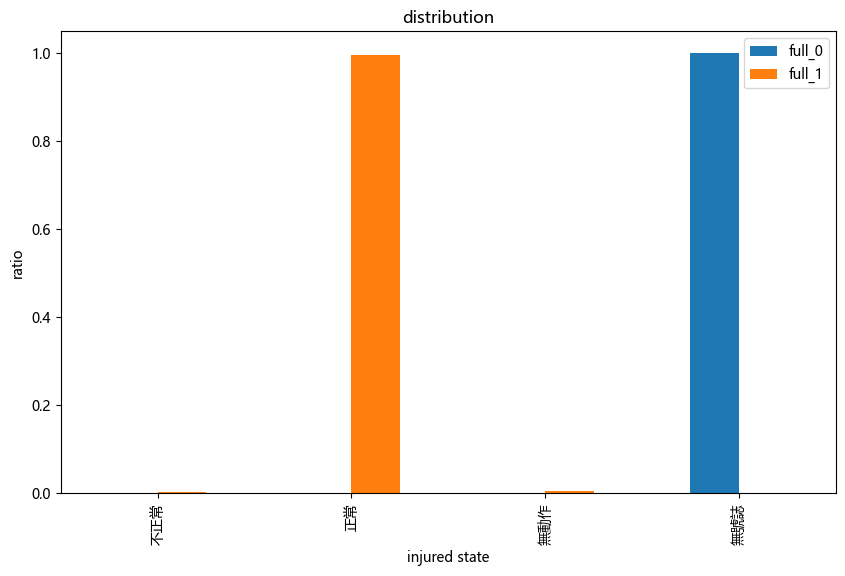

In [243]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # Window
# plt.rcParams['font.sans-serif']=['Arial Unicode Ms'] # Mac
plt.rcParams['axes.unicode_minus'] = False

injury_distribution = pd.DataFrame({
    'full_0': full_0['號誌-號誌動作名稱'].value_counts(normalize=True),
    'full_1': full_1['號誌-號誌動作名稱'].value_counts(normalize=True)
})

print(injury_distribution)

# 可視化分布差異
injury_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('distribution')
plt.xlabel('injured state')
plt.ylabel('ratio')
plt.show()

## Pickle save

In [15]:
# import pickle

# with open('../Version3/GridSearch/全部mapper資料.pkl', 'wb') as f:
#     pickle.dump(results, f)

# Grid search

In [14]:
n_intervals_range = range(3, 6)
overlap_frac_range = [round(0.4 + i * 0.05, 2) for i in range(5)]

print(n_intervals_range)
print(overlap_frac_range)

results = []

for n_intervals in n_intervals_range:
    for overlap_frac in overlap_frac_range:
        
        start_time = time.time()

        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=n_intervals,
                overlap_frac=overlap_frac
            ),
            clustering=FailSafeClustering(
                clustering=AgglomerativeClustering(5, linkage='single'),
                verbose=False
            )
        )

        mapper_graph = mapper_algo.fit_transform(mapper_numpy, lens1)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)
        
        results.append({
            'n_intervals': n_intervals,
            'overlap_frac': overlap_frac,
            'graph': mapper_graph
        })
        
        print(f"Added parameters: n_intervals={n_intervals}, overlap_frac={overlap_frac}")

range(3, 6)
[0.4, 0.45, 0.5, 0.55, 0.6]
312.017689704895
Added parameters: n_intervals=3, overlap_frac=0.4
350.89471220970154
Added parameters: n_intervals=3, overlap_frac=0.45
365.489159822464
Added parameters: n_intervals=3, overlap_frac=0.5
609.3233876228333
Added parameters: n_intervals=3, overlap_frac=0.55
942.5379445552826
Added parameters: n_intervals=3, overlap_frac=0.6
222.39931416511536
Added parameters: n_intervals=4, overlap_frac=0.4
245.39600348472595
Added parameters: n_intervals=4, overlap_frac=0.45
217.80010890960693
Added parameters: n_intervals=4, overlap_frac=0.5
203.29131937026978
Added parameters: n_intervals=4, overlap_frac=0.55
293.76072430610657
Added parameters: n_intervals=4, overlap_frac=0.6
190.67405200004578
Added parameters: n_intervals=5, overlap_frac=0.4
178.24561524391174
Added parameters: n_intervals=5, overlap_frac=0.45
161.37064266204834
Added parameters: n_intervals=5, overlap_frac=0.5
170.47949314117432
Added parameters: n_intervals=5, overlap_frac

In [26]:
# for idx, graph in enumerate(results):
#     mapper_plot = MapperLayoutInteractive(
#         graph['graph'],
#         colors=dummy_data[['死亡']].to_numpy(),
#         cmap='jet',
#         agg=np.nanmean,
#         dim=3,
#         iterations=30,
#         seed=6,
#         width=800,
#         height=500
#     )

#     fig = mapper_plot.plot()

#     fig.show(config={'scrollZoom': True})

#     fig.write_html(f"mapper_plot_{idx}.html")

# Example parameters

1. 以圖像為例，較高的interval(10)配上較高的overlap(0.65)有較直觀的效果，而使用clustering方法設為10的華德法也較好，同時範例將PCA設為2。[連結](https://pypi.org/project/tda-mapper/0.2.0/)
2. 但是將PCA調高雖然增加計算量，但是也在interval不設置大麼多的情況下得到好的結果
3. 設置高的clsustering數量可以得出較好的捕捉局部資料lens = PCA(2).fit_transform(X)

In [41]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True) 

pca = PCA(n_components=2)
lens = pca.fit_transform(X)

explained_variance_ratio  = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

0.2850936482369889
[0.14890594 0.13618771]


In [3]:
# mapper_algo = MapperAlgorithm(
#     cover=CubicalCover(
#         n_intervals=10,
#         overlap_frac=0.65),
#     clustering = FailSafeClustering(
#         clustering = AgglomerativeClustering(10, linkage='ward'),
#         verbose = False)
# )
# mapper_graph = mapper_algo.fit_transform(X, lens)

# mapper_plot = MapperLayoutInteractive(
#     mapper_graph,
#     colors=y,                       
#     cmap='jet',
#     agg=np.nanmean,
#     dim=3,
#     iterations=400,
#     seed=42,
#     title='digit (mean)',
#     width=600,
#     height=600)

# fig_mean1 = mapper_plot.plot()
# fig_mean1.show(config={'scrollZoom': True})